<a href="https://colab.research.google.com/github/K-107/TimeSeriesForecast_Informer2020/blob/main/informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 참고

 https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-5.informer-post/

 https://doheon.github.io/%EC%84%B1%EB%8A%A5%EB%B9%84%EA%B5%90/time-series/ci-6.compare-post/

 https://doheon.github.io/%EB%85%BC%EB%AC%B8%EB%B2%88%EC%97%AD/pt-Informer-post/

In [ ]:
!git clone https://github.com/K-107/TimeSeriesForecast-Informer.git

# 원작자의 레포지토리에서 models, utils폴더만 필요하므로 클론 후 나머지 파일들은 삭제해도 무방하다.

Cloning into 'TimeSeriesForecast-Informer'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 55 (delta 14), reused 36 (delta 5), pack-reused 0
Unpacking objects: 100% (55/55), done.


# ETT 데이터셋으로 해보자!

In [ ]:
# ETT 데이터셋 가져오기
!git clone https://github.com/zhouhaoyi/ETDataset.git

Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 187 (delta 66), reused 13 (delta 2), pack-reused 0
Receiving objects: 100% (187/187), 3.85 MiB | 6.78 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
import pandas as pd
import os

def save_df(path, df_name, pred_num):
  df = pd.read_csv(path+'/'+df_name)

  # pred_num을 제외한 훈련 데이터 csv로 저장
  df_train = df[:-pred_num]
  df_train.to_csv(path + '/df_train.csv', index=False)

  df_test = df[-pred_num:]
  df_test.to_csv(path + '/df_test.csv', index=False)

In [ ]:
path = '/content/ETDataset/ETT-small'
df_name = 'ETTh1.csv'
pred_num = 24*7 # 일주일

save_df(path, df_name, pred_num)

In [ ]:
# repository에 있는 models, utils폴더가 있는 곳에서 진행

%cd /content/TimeSeriesForecast-Informer

/content/TimeSeriesForecast-Informer


### Modeul Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

from models.model import Informer

### Util function

In [ ]:
# standard scler 구현
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean

######## 아래는 함수다!! ##########

# 시간 특징을 freq에 따라 추출
# time_features가 이럴 수 밖에 없는 이유는
# models -> embed.py -> 59번 줄 class TemporalEmbedding에 이렇게 짜져있다.

def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

### Make Dataset


학습을 진행할 때 필요한 4가지의 변수를 반환하는 Dataset을 생성한다.

input, output, intput의 timestamp, output의 timestamp의 순서대로 값을 반환한다.

모델이 decoder에서 결과를 만들 때 label_len만큼 이전 데이터를 참고한다는 특징이 있어서 input의 길이가 seq_len이고 output의 길이가 pred_len일 때 intput과 output의 형태는 아래와 같다.

0번째 index의 데이터

input: [0, seq_len]

output: [seq_len - label_len:seq_len + pred_len]

In [ ]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

### Load Data

column의 이름을 date, value로 바꿔주고 date를 datetime 형식으로 변환해준다.

sklearn의 MinMaxScaler를 이용하여 minmax scaling 해준 후 마지막 일주일의 데이터를 제외한 데이터를 최종 학습 데이터로 설정한다.

In [ ]:
# ETT train 데이터

data = pd.read_csv("/content/ETDataset/ETT-small/df_train.csv", encoding='CP949')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17215,2018-06-18 07:00:00,8.239,4.689,2.452,2.274,5.665,2.071,9.286000
17216,2018-06-18 08:00:00,2.746,4.421,-2.985,1.812,5.787,2.284,9.145000
17217,2018-06-18 09:00:00,-3.818,4.153,-9.737,0.817,5.544,2.224,9.778000
17218,2018-06-18 10:00:00,-4.823,3.014,-8.138,0.959,3.533,1.401,9.989000


In [ ]:
# 이걸 안해줫네....

# min_max_scaler = MinMaxScaler()
# data["value"] = min_max_scaler.fit_transform(data["value"].to_numpy().reshape(-1,1)).reshape(-1)
# data = data[["date", "value"]]
# data

In [ ]:
# 24시간, 7일 = 1주일

data_train = data.iloc[:-24*7].copy()

In [ ]:
# 아까 만든 Dataset class를 이용해서 데이터셋을 생성한다.

pred_len = 24*7

seq_len = pred_len # 인풋 크기, input sequence length of Informer encoder
label_len = pred_len # 디코더에서 참고할 크기, start token length of Informer decoder
pred_len = pred_len # 예측할 크기, prediction sequence length

batch_size = 10
shuffle_flag = True
num_workers = 0
drop_last = True



dataset = Dataset_Pred(dataframe=data_train,
                       scale=True,
                       size = (seq_len, label_len,pred_len))

data_loader = DataLoader(dataset,
                         batch_size=batch_size,
                         shuffle=shuffle_flag,
                         num_workers=num_workers,
                         drop_last=drop_last)

### Train

In [ ]:
enc_in = 7 # encoder input size
dec_in = 7 # decoder input size
c_out = 7 # output size
device = torch.device("cuda:0") # GPU 번호

model = Informer(enc_in,
                 dec_in,
                 c_out,
                 seq_len,
                 label_len,
                 pred_len,
                 device = device).to(device)
                 
learning_rate = 1e-4
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 조기 종료 코드

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=3, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.train_loss_min = np.Inf
        self.delta = delta

    def __call__(self, train_loss):

        train_loss = np.average(train_loss)
        score = -train_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
# EarlyStopping 추가

train_epochs = 10
model.train()
progress = tqdm(range(train_epochs))
early_stopping = EarlyStopping(patience=3, verbose=True)

for epoch in progress:
  train_loss = []
  for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    model_optim.zero_grad()
    pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
    loss = criterion(pred, true)
    train_loss.append(loss.item())
    loss.backward()
    model_optim.step()
    print(f'{i} 에폭 종료!')
    early_stopping(train_loss)
    if early_stopping.early_stop:
      print("Early stopping")
      break

    train_loss = np.average(train_loss)
    progress.set_description("loss: {:0.6f}".format(train_loss))

loss: 0.047854:   3%|▎         | 1/30 [04:58<2:24:28, 298.90s/it]

  1 에폭 종료!


loss: 0.042563:   7%|▋         | 2/30 [09:58<2:19:37, 299.18s/it]

  2 에폭 종료!


loss: 0.042300:  10%|█         | 3/30 [14:57<2:14:42, 299.37s/it]

  3 에폭 종료!


loss: 0.034134:  13%|█▎        | 4/30 [19:57<2:09:48, 299.57s/it]

  4 에폭 종료!


loss: 0.032613:  17%|█▋        | 5/30 [24:57<2:04:53, 299.73s/it]

  5 에폭 종료!


loss: 0.030530:  20%|██        | 6/30 [29:57<1:59:56, 299.83s/it]

  6 에폭 종료!


loss: 0.027356:  23%|██▎       | 7/30 [34:57<1:54:55, 299.79s/it]

  7 에폭 종료!


loss: 0.025421:  27%|██▋       | 8/30 [39:57<1:49:54, 299.75s/it]

  8 에폭 종료!


loss: 0.023440:  30%|███       | 9/30 [44:56<1:44:52, 299.65s/it]

  9 에폭 종료!


loss: 0.021176:  33%|███▎      | 10/30 [49:56<1:39:51, 299.58s/it]

  10 에폭 종료!


loss: 0.021671:  37%|███▋      | 11/30 [54:54<1:34:47, 299.34s/it]

  11 에폭 종료!
EarlyStopping counter: 1 out of 3


loss: 0.018306:  40%|████      | 12/30 [59:54<1:29:47, 299.30s/it]

  12 에폭 종료!


loss: 0.016949:  43%|████▎     | 13/30 [1:04:52<1:24:43, 299.02s/it]

  13 에폭 종료!


loss: 0.016096:  47%|████▋     | 14/30 [1:09:51<1:19:42, 298.93s/it]

  14 에폭 종료!


loss: 0.015285:  50%|█████     | 15/30 [1:14:49<1:14:40, 298.73s/it]

  15 에폭 종료!


loss: 0.014338:  53%|█████▎    | 16/30 [1:19:48<1:09:43, 298.80s/it]

  16 에폭 종료!


loss: 0.013463:  57%|█████▋    | 17/30 [1:24:46<1:04:43, 298.76s/it]

  17 에폭 종료!


loss: 0.012018:  60%|██████    | 18/30 [1:29:46<59:46, 298.84s/it]  

  18 에폭 종료!


loss: 0.011336:  63%|██████▎   | 19/30 [1:34:44<54:47, 298.82s/it]

  19 에폭 종료!


loss: 0.011504:  67%|██████▋   | 20/30 [1:39:43<49:47, 298.73s/it]

  20 에폭 종료!
EarlyStopping counter: 1 out of 3


loss: 0.009872:  70%|███████   | 21/30 [1:44:44<44:55, 299.46s/it]

  21 에폭 종료!


loss: 0.010035:  73%|███████▎  | 22/30 [1:49:43<39:55, 299.46s/it]

  22 에폭 종료!
EarlyStopping counter: 1 out of 3


loss: 0.010065:  77%|███████▋  | 23/30 [1:54:42<34:53, 299.14s/it]

  23 에폭 종료!
EarlyStopping counter: 2 out of 3


loss: 0.009257:  80%|████████  | 24/30 [1:59:40<29:53, 298.91s/it]

  24 에폭 종료!


loss: 0.008617:  83%|████████▎ | 25/30 [2:04:38<24:53, 298.62s/it]

  25 에폭 종료!


loss: 0.008306:  87%|████████▋ | 26/30 [2:09:36<19:53, 298.45s/it]

  26 에폭 종료!


loss: 0.007575:  90%|█████████ | 27/30 [2:14:34<14:54, 298.33s/it]

  27 에폭 종료!


loss: 0.007628:  93%|█████████▎| 28/30 [2:19:33<09:56, 298.34s/it]

  28 에폭 종료!
EarlyStopping counter: 1 out of 3


loss: 0.006808:  97%|█████████▋| 29/30 [2:24:31<04:58, 298.36s/it]

  29 에폭 종료!


loss: 0.006591: 100%|██████████| 30/30 [2:29:30<00:00, 299.03s/it]

  30 에폭 종료!


### Evaluate

학습된 모델을 이용해서 실제 마지막 일주일의 데이터를 예측

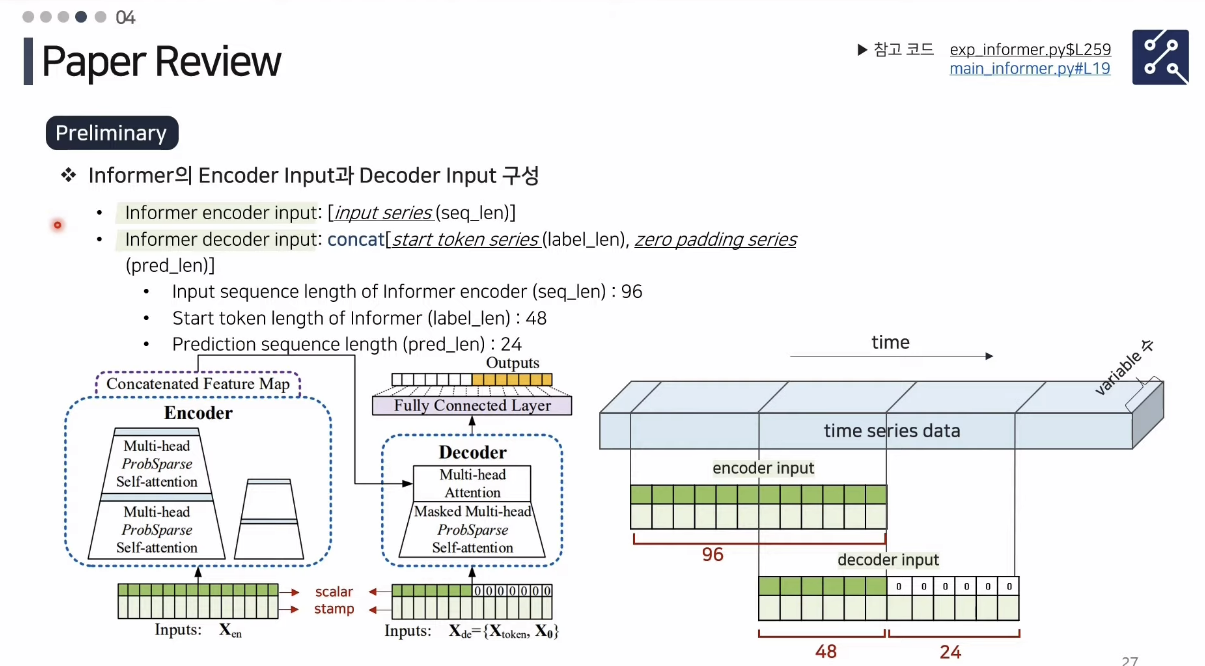

In [ ]:
import time

now = time.time()
scaler = dataset.scaler # Load Data에서 사용한 scaler로 훈련 때 사용한 StandardScaler를 사용한다.
df_test = data_train.copy() # 훈련한 데이터를 입력으로 넣어서 일주일 후를 예측!

# 훈련 데이터에서 사용한 StandardScaler로 변환
df_scaled = scaler.transform(df_test.drop(['date'], axis=1))
# datetime 형식으로 변환
df_test["date"] = pd.to_datetime(df_test["date"].values)
df_test = pd.concat([df_test["date"], df_scaled] ,axis=1)

delta = df_test["date"][1] - df_test["date"][0] # delta는 1시간이다. Timedelta('0 days 01:00:00')
for i in range(pred_len): # pred_len = 24*7이다.
    df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True) # df_test["date"]의 맨 뒤에 1시간씩 붙인다. 
df_test = df_test.fillna(0)

df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy() # 0이 아닌 맨 뒤에서 168개
df_test_y = df_test.iloc[-label_len-pred_len:].copy() # 0을 포함하는 맨 뒤에서 336개

df_test_numpy = df_test.to_numpy()[:,1:].astype("float") # value만 잡은 것이다.
test_time_x = time_features(df_test_x, freq=dataset.freq) # 인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] # 인풋 데이터, 0이 아닌 맨 뒤에서 168개


test_time_y = time_features(df_test_y, freq=dataset.freq) # 아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:]
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) # 예측하는 부분을 0으로 채워준다.


############## 결국에 아래 4가지를 만들어야한다!################
############## 디코더 입력의 0으로 패딩된 곳만 예측한다!!#######
test_time_x = test_time_x # 인코더 입력
test_time_y = test_time_y # 디코더 입력
test_data_x = test_data_x.astype(np.float64) # 인코더 입력
test_data_y = test_data_y.astype(np.float64) # 디코더 입력

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

preds = []

with torch.no_grad():
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        preds = outputs.detach().cpu().numpy()

preds = scaler.inverse_transform(preds[0])

df_test.iloc[-pred_len:, 1:] = preds
print(time.time() - now)

0.6539757251739502


In [ ]:
df_test

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,-0.223925,-0.093794,-0.404560,-0.215820,0.993504,0.829010,1.985171
1,2016-07-01 01:00:00,-0.243008,-0.060793,-0.420338,-0.235717,0.940933,0.880899,1.667092
2,2016-07-01 02:00:00,-0.319340,-0.225797,-0.451747,-0.274958,0.626371,0.624801,1.667092
3,2016-07-01 03:00:00,-0.328882,-0.126795,-0.451747,-0.255061,0.652225,0.726906,1.349129
4,2016-07-01 04:00:00,-0.290716,-0.126795,-0.420338,-0.215820,0.704796,0.726906,0.990246
...,...,...,...,...,...,...,...,...
17247,2018-06-19 15:00:00,-1.249500,2.931972,-3.811719,1.038572,2.621937,1.062552,10.286564
17248,2018-06-19 16:00:00,0.933784,2.148842,-1.540406,0.664800,2.597225,1.076296,9.624595
17249,2018-06-19 17:00:00,7.250301,1.965626,4.053335,0.627593,3.322728,1.142469,9.437329
17250,2018-06-19 18:00:00,7.850347,1.823753,4.416747,0.437544,3.461181,1.110035,10.014006


### Visualization

In [ ]:
df_answer = pd.read_csv("/content/ETDataset/ETT-small/df_test.csv", encoding='CP949')
df_answer

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2018-06-19 20:00:00,7.837,2.277,4.939,0.959,2.894,1.005,7.105
1,2018-06-19 21:00:00,8.372,1.808,5.259,0.071,2.559,0.944,4.573
2,2018-06-19 22:00:00,10.047,3.885,7.533,2.203,2.498,0.975,5.135
3,2018-06-19 23:00:00,11.186,3.550,8.919,2.310,2.345,0.792,5.909
4,2018-06-20 00:00:00,14.535,5.224,9.666,3.198,4.599,1.310,6.542
...,...,...,...,...,...,...,...,...
163,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904
164,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044
165,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271
166,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def visualization(feature_name):
  print(f'==============={feature_name}==========================')
  real = df_answer[feature_name].to_numpy()
  result = df_test[feature_name].iloc[-24*7:].to_numpy()

  plt.figure(figsize=(20,5))
  plt.plot(real, label="real")
  plt.plot(result, label="predict")
  plt.legend()
  plt.show()

  mae = mean_absolute_error(real, result)
  print("MAE : ", mae)
  print('==========================================================')

===============HUFL==========================


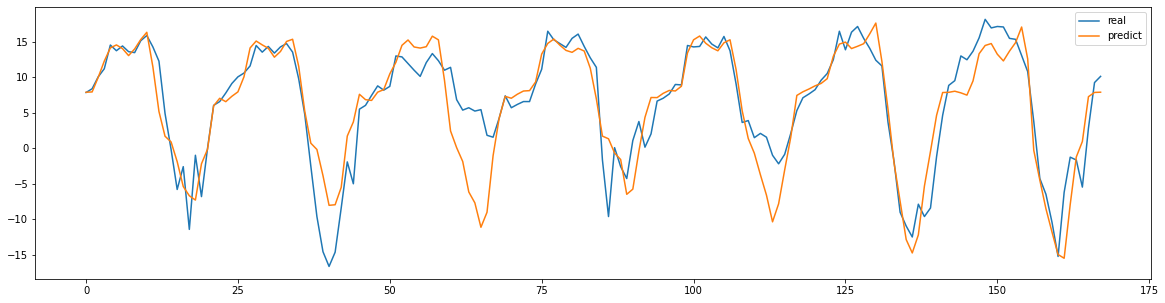

MAE :  2.770301565166874
===============HULL==========================


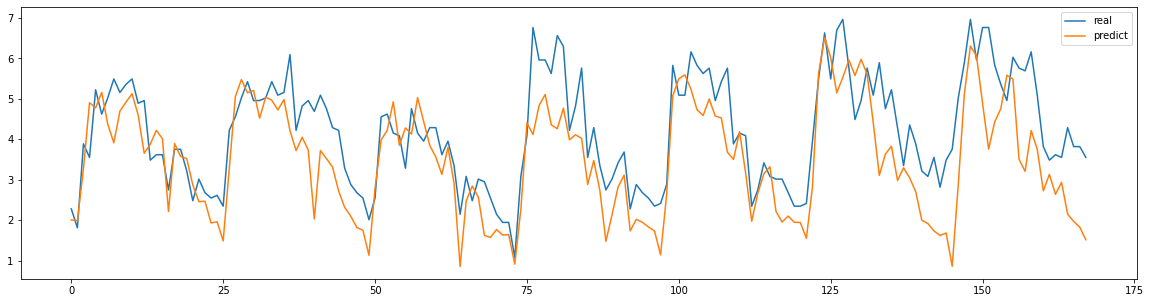

MAE :  0.8665863256350994
===============MUFL==========================


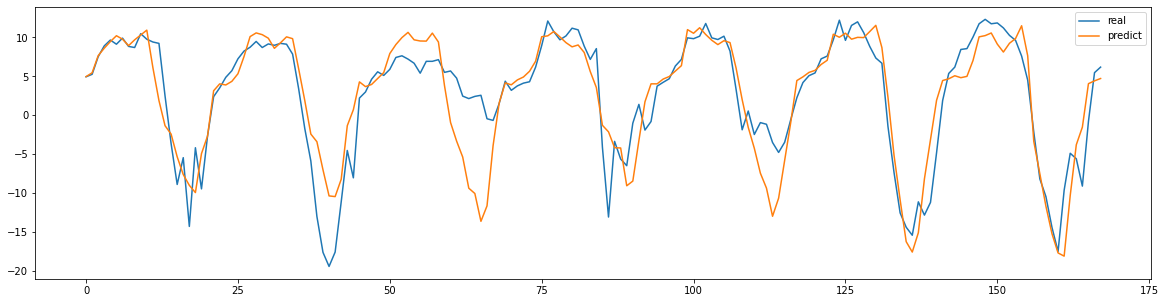

MAE :  2.758418493196913
===============MULL==========================


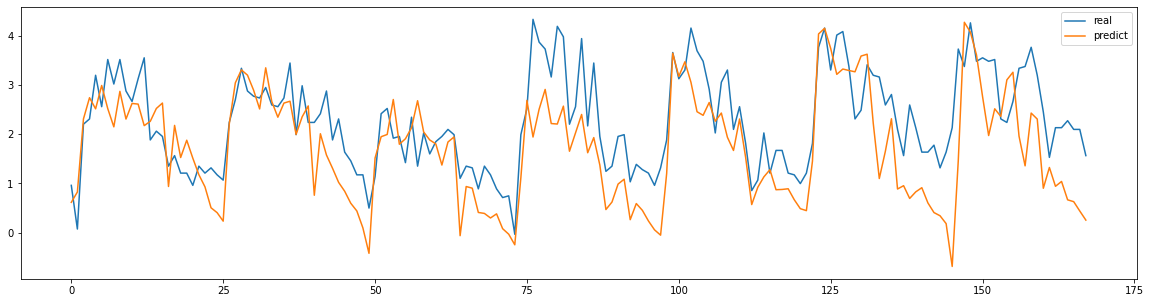

MAE :  0.7372845715727462
===============LUFL==========================


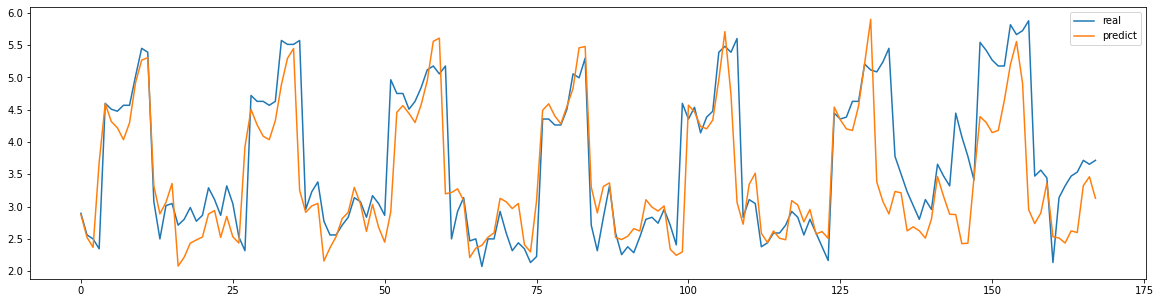

MAE :  0.455424004011492
===============LULL==========================


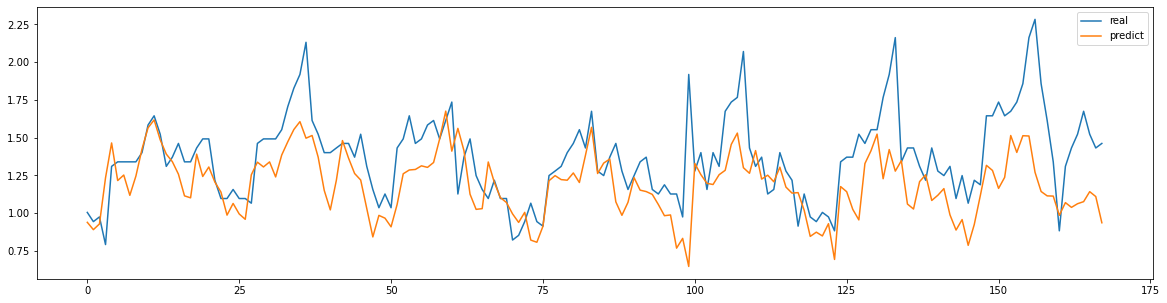

MAE :  0.21644864408618672
===============OT==========================


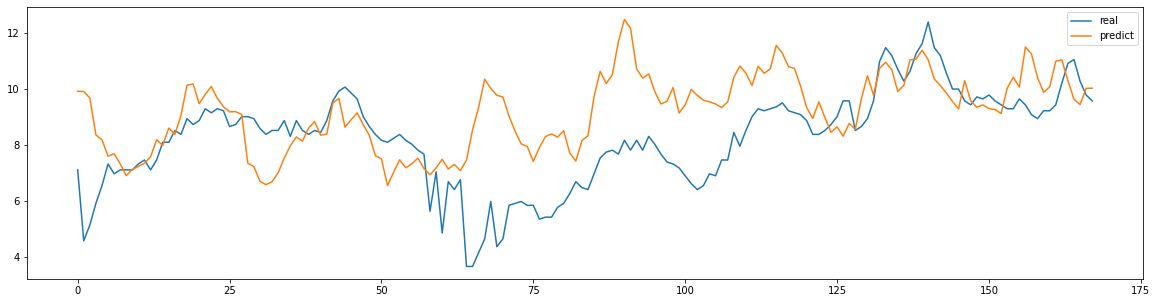

MAE :  1.4362382479473768


In [ ]:
for feature in df_answer.drop(['date'],axis=1).columns:
  visualization(feature)